In [196]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
from nltk import sent_tokenize, word_tokenize
import re
import spacy
nlp = spacy.load('en_core_web_sm')
from sklearn.feature_extraction.text import TfidfVectorizer
import string

#  EDA and Cleaning the data. 

In [197]:
data = pd.read_csv('spam_ham_dataset.csv')
data.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [198]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


In [199]:
data = data.drop('Unnamed: 0', axis = 1)

In [200]:
count = data.label.value_counts()
count

ham     3672
spam    1499
Name: label, dtype: int64

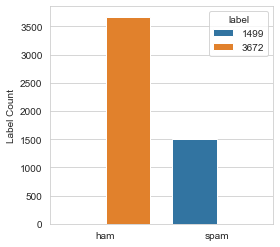

<Figure size 432x288 with 0 Axes>

In [201]:
sns.set_style("whitegrid")
plt.figure(figsize=(4,4))
ax = sns.barplot(x = ['ham','spam'], y = count, hue = count)
ax.set_ylabel('Label Count')
plt.show()
plt.savefig('type.jpg') 

In [202]:
# Converting data to lower case
data['clean_text'] = data['text'].apply(lambda x: x.lower())
data.head()

,label,text,label_num,clean_text
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0,subject: enron methanol ; meter # : 988291\r\n...
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,"subject: hpl nom for january 9 , 2001\r\n( see..."
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,"subject: neon retreat\r\nho ho ho , we ' re ar..."
3,spam,"Subject: photoshop , windows , office . cheap ...",1,"subject: photoshop , windows , office . cheap ..."
4,ham,Subject: re : indian springs\r\nthis deal is t...,0,subject: re : indian springs\r\nthis deal is t...


In [203]:
# remove 'subject' as it is present in corpus.
def remove(text):
    return re.sub(r'subject','',text)
    
data['clean_text'] = data['clean_text'].apply(lambda x: remove(x))

In [204]:
# removing urls
def rem_url(text):
    return re.sub(r"https?://\S+|www\.\S+", '',text)

data['clean_text'] = data['clean_text'].apply(lambda x: rem_url(x))

In [205]:
# removing escape sequences:  \r and \n
def rem_spec_char(text):
    return re.sub(r'\W+(r|n)*',' ',text)

data['clean_text'] = data['clean_text'].apply(lambda x: rem_spec_char(x))
data.head()

,label,text,label_num,clean_text
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0,enron methanol meter 988291 this is a follow ...
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,hpl om for january 9 2001 see attached file h...
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,eon etreat ho ho ho we e around to that most ...
3,spam,"Subject: photoshop , windows , office . cheap ...",1,photoshop windows office cheap main trending ...
4,ham,Subject: re : indian springs\r\nthis deal is t...,0,e indian springs this deal is to book the tec...


In [206]:
# removing punctuations
def rem_punct(text):
    return text.translate(str.maketrans('','',string.punctuation))

data['clean_text'] = data.clean_text.apply(lambda x : rem_punct(x))
data.head()

,label,text,label_num,clean_text
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0,enron methanol meter 988291 this is a follow ...
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,hpl om for january 9 2001 see attached file h...
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,eon etreat ho ho ho we e around to that most ...
3,spam,"Subject: photoshop , windows , office . cheap ...",1,photoshop windows office cheap main trending ...
4,ham,Subject: re : indian springs\r\nthis deal is t...,0,e indian springs this deal is to book the tec...


In [207]:
# checking content length of each email
data['length'] = data['clean_text'].apply(lambda x: len(x))
data.head()

,label,text,label_num,clean_text,length
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0,enron methanol meter 988291 this is a follow ...,284
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,hpl om for january 9 2001 see attached file h...,72
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,eon etreat ho ho ho we e around to that most ...,2323
3,spam,"Subject: photoshop , windows , office . cheap ...",1,photoshop windows office cheap main trending ...,385
4,ham,Subject: re : indian springs\r\nthis deal is t...,0,e indian springs this deal is to book the tec...,309


In [208]:
data.describe()
# max length is 21362

,label_num,length
count,5171.000000,5171.000000
mean,0.289886,882.800812
std,0.453753,1299.938478
min,0.000000,1.000000
25%,0.000000,203.000000
50%,0.000000,444.000000
75%,1.000000,1028.000000
max,1.000000,21362.000000


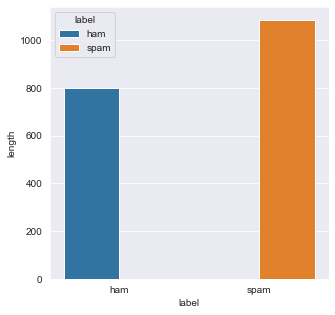

<Figure size 432x288 with 0 Axes>

In [209]:
# plotting email length and their relation with ham or spam data
sns.set_style("darkgrid")
plt.figure(figsize=(5,5))
ax = sns.barplot(y = 'length', x = 'label', data = data, hue = 'label', ci=None)
plt.show()
plt.savefig('lengthbarplot.jpg')

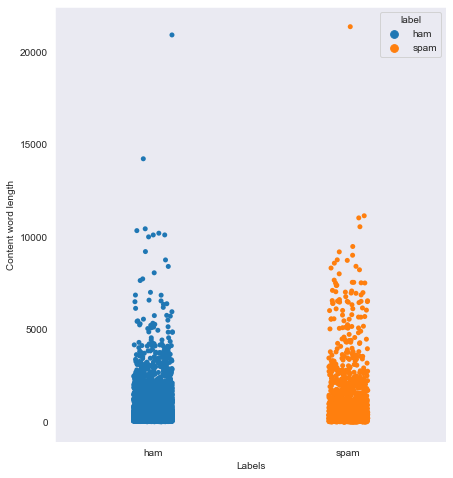

<Figure size 432x288 with 0 Axes>

In [210]:
sns.set_style("dark")
plt.figure(figsize=(7,8))
ax = sns.stripplot(y = 'length', x = 'label', data = data, hue = 'label')
ax.set_xlabel('Labels')
ax.set_ylabel('Content word length')
plt.show()
plt.savefig('lengthscatterplot.jpg')

#  Vectorizing data using Tfidf vectorizer

In [211]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(data['clean_text'])
X.shape

(5171, 49885)

In [213]:
y = data['label_num']

In [212]:
tfidf.vocabulary_

{'enron': 19809,
 'methanol': 33054,
 'meter': 33047,
 '988291': 4629,
 'this': 44169,
 'is': 28268,
 'follow': 22498,
 'up': 46118,
 'to': 44557,
 'the': 44047,
 'ote': 35570,
 'gave': 23424,
 'you': 49358,
 'on': 35034,
 'monday': 33754,
 '00': 0,
 'preliminary': 38038,
 'flow': 22383,
 'data': 15637,
 'provided': 38581,
 'by': 11095,
 'daren': 15579,
 'please': 37404,
 'override': 35797,
 'pop': 37667,
 'daily': 15481,
 'volume': 47220,
 'presently': 38103,
 'zero': 49600,
 'eflect': 18825,
 'activity': 5176,
 'can': 11372,
 'obtain': 34527,
 'from': 22939,
 'gas': 23369,
 'control': 14284,
 'change': 12246,
 'eeded': 18689,
 'asap': 7443,
 'for': 22559,
 'economics': 18472,
 'purposes': 38831,
 'hpl': 26206,
 'om': 34956,
 'january': 28606,
 '2001': 1116,
 'see': 40154,
 'attached': 7778,
 'file': 22021,
 'hplnol': 26213,
 '09': 214,
 'xls': 48920,
 'eon': 19947,
 'etreat': 20690,
 'ho': 25853,
 'we': 47697,
 'around': 7335,
 'that': 44039,
 'most': 33954,
 'wonderful': 48369,
 'ti

#  Training the data and using various ML Algos

In [214]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30,shuffle = True, random_state = 42)

In [215]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix

#  Naive bayes

In [216]:
from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

MultinomialNB()

In [217]:
# Making predictions
prediction = nb_model.predict(X_test)

print('\n',classification_report(y_test, prediction))
print(f'\n accuracy is = {accuracy_score(y_test, prediction)*100}%')


               precision    recall  f1-score   support

           0       0.85      1.00      0.92      1121
           1       1.00      0.53      0.69       431

    accuracy                           0.87      1552
   macro avg       0.92      0.77      0.81      1552
weighted avg       0.89      0.87      0.86      1552


 accuracy is = 86.98453608247422%


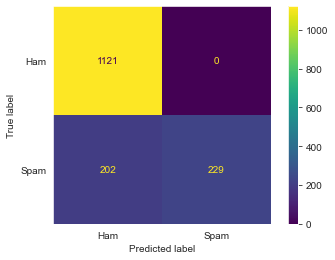

In [227]:
plot_confusion_matrix(nb_model,X_test,y_test,display_labels=['Ham','Spam'])

#  Logistic Regression

In [219]:
from sklearn.linear_model import LogisticRegression
regression_model = LogisticRegression()
regression_model.fit(X_train, y_train)

LogisticRegression()

In [220]:
# making predictions
predictions = regression_model.predict(X_test)

print('\n',classification_report(y_test, predictions))
print(f'\n accuracy is = {accuracy_score(y_test, predictions)*100}%')


               precision    recall  f1-score   support

           0       0.99      0.98      0.99      1121
           1       0.96      0.97      0.97       431

    accuracy                           0.98      1552
   macro avg       0.97      0.98      0.98      1552
weighted avg       0.98      0.98      0.98      1552


 accuracy is = 98.13144329896907%


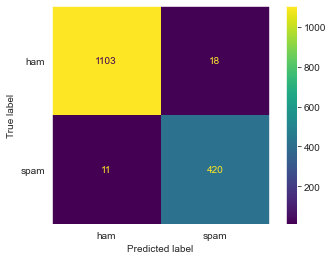

In [221]:
plot_confusion_matrix(regression_model,X_test,y_test,display_labels=['ham','spam'])

#  Linear SVM

In [222]:
from sklearn.svm import LinearSVC
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)

LinearSVC()

In [223]:
# making predictions
predictions = svm_model.predict(X_test)

print('\n',classification_report(y_test, predictions))
print(f'\n accuracy is = {accuracy_score(y_test, predictions)*100}%')


               precision    recall  f1-score   support

           0       1.00      0.99      0.99      1121
           1       0.97      0.99      0.98       431

    accuracy                           0.99      1552
   macro avg       0.98      0.99      0.98      1552
weighted avg       0.99      0.99      0.99      1552


 accuracy is = 98.71134020618557%


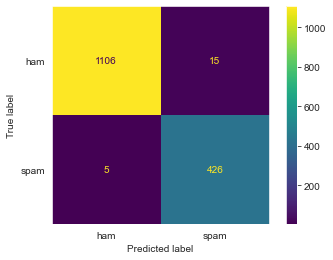

In [224]:
plot_confusion_matrix(svm_model,X_test,y_test,display_labels=['ham','spam'])

#  Saving the model

In [225]:
import joblib

In [226]:
joblib.dump(svm_model, 'Spam_svm.pkl')

['Spam_svm.pkl']